<img src="./img/metro_madrid.jpg" alt="drawing" width="500"/>

# Transporte y renta en la Comunidad de Madrid

### TEMA

Este proyecto busca arrojar luz sobre los patrones de comportamiento en el transporte de los ciudadanos de la Comunidad de Madrid, estudiando posibles vínculos con su renta. Para ello, se utiliza la [Encuesta de Movilidad del Consorcio Regional](https://datos.comunidad.madrid/dataset/resultados-edm2018) de Transportes de Madrid (CRTM), realizada en el 2018.

Para los cálculos de la renta, se utilizan diferentes tablas extraídas de la [Encuesta de Condiciones de Vida](https://ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=ultiDatos&idp=1254735976608) del INE, para el año 2018

### HIPÓTESIS

La hipótesis principal de este proyecto es que **existe una relación entre la renta y el uso del transporte en la Comunidad de Madrid**. En concreto, se buscará contrastar:
+ Si las rentas más altas eligen el coche como primera opción para desplazamientos laborales y por placer.
+ Las rentas bajas, para trabajar, utilizan más el transporte público que el coche.
+ Las mujeres utilizan más el transporte público para desplazamientos laborales, sin tener en cuenta la renta.
    + Lo que, unido al segundo punto, explicaría que las mujeres no usan más el transporte público por deseo sino por necesidad.
+ Los hombres utilizan más el transporte privado para desplazamientos por placer


### SUPUESTOS
Dados los datos utilizados, hemos de tener en cuenta varios puntos:
+ Se está utilizando la última encuesta publicada por el CRTM (en serio).
    + Sí se cuentan con los datos de uso del Metro de Madrid, que en 2023 volvieron a niveles pre-pandemia. Por tanto, podemos suponer que no han cambiado las pautas de comportamiento en un nivel agregado
+ No contamos con la renta de los encuestados. Para ello generaremos un dato *proxy*, que estimaremos en función de las condiciones socioeconómicas de los encuestados (edad, ocupación, género, grado de educación, y si cuenta con coche).
    + Renta != Riqueza. Estimaremos la cantidad de **generar** , no de **poseer**. Una persona sin trabajo pero con patrimonio no quedará reflejada en este estudio.
    + Por disponibilidad de los datos, se utilizarán las medias de las rentas. En función de disponibilidad de los datos, es posible que se recoja la media española en lugar de la de la Comunidad de Madrid.
+ Los datos sólo tienen en cuenta días estrictamente laborales (Lunes-Jueves)
+ Si bien no tiene impacto a primera vista sobre las hipótesis, se realizará un estudio de impacto de la **meteorología** sobre el uso de unos u otros medios transportes.


## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

In [245]:
import hashlib
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [246]:
df_transp = pd.DataFrame(pd.read_csv("./data/treated/transp.csv"))

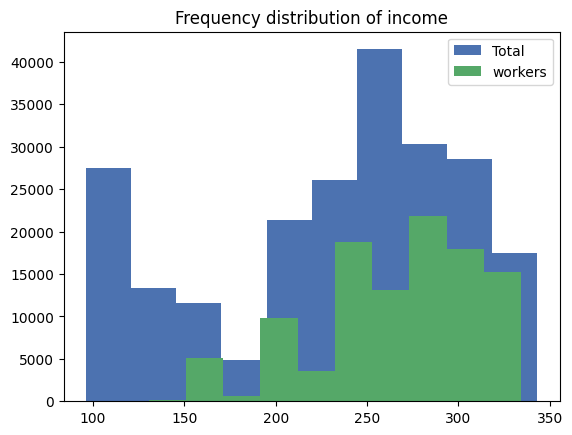

In [198]:
plt.style.use('seaborn-v0_8-deep')
plt.title("Frequency distribution of income")
plt.hist(df_transp['income'],label="Total")
plt.hist(df_transp[df_transp['activity'] == "worker"]['income'],label="workers")
plt.legend();

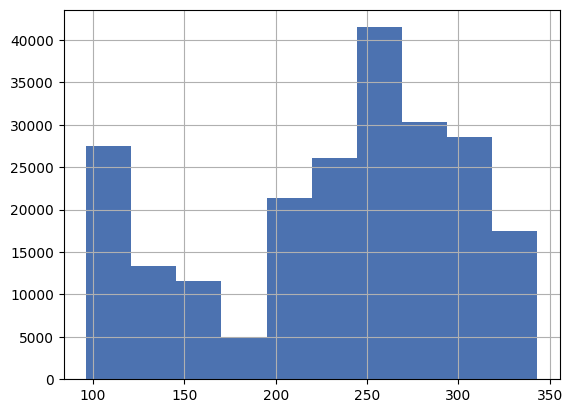

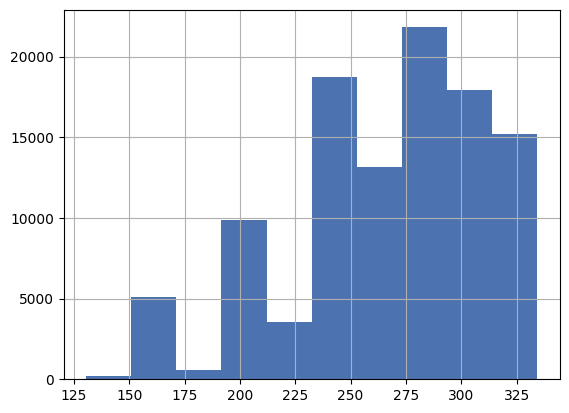

In [190]:
###TODO: get the hists right
plt.figure()
inc_hist = df_transp['income'].hist()
inc_hist.get_figure().savefig('./img/plots/hists/income.png')
plt.figure()
worker_inc_hist = df_transp[df_transp['activity'] == "worker"]['income'].hist()
worker_inc_hist.get_figure().savefig('./img/plots/hists/workers_income.png')



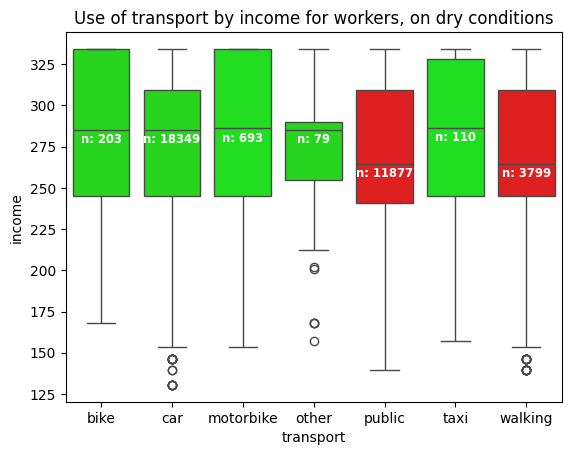

In [277]:
import seaborn as sns
import matplotlib.colors as mcolors


df_transp_dry_work = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work")] 
###Colors
transp_medians = df_transp_dry_work.groupby('transport')['income'].median().sort_index(ascending=True)
initial_color = np.array([1, 0, 0])
final_color = np.array([0, 1, 0])
norm_medians = (transp_medians-transp_medians.min()) / (transp_medians.max() - transp_medians.min())
colors_medians = [mcolors.to_hex(initial_color * (1 - n) + final_color * n) for n in norm_medians]

### HIPÓTESIS 1: Análisis
#Painting the plot
ax = sns.boxplot(x=df_transp_dry_work['transport'],y=df_transp_dry_work['income'],hue=df_transp_dry_work['transport'],order=transp_medians.index,hue_order=transp_medians.index, palette=colors_medians)
#Printing number of observations
nobs = df_transp_dry_work.groupby('transport').size().sort_index(ascending=True).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
pos=range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    plt.text(pos[tick], transp_medians.iloc[tick] - 8, nobs[tick], horizontalalignment='center', size='small', color='w', weight='semibold')

plt.title("Use of transport by income for workers, on dry conditions")
plt.savefig("./img/plots/box/transport_income_workers_dry.png");
plt.show()

In [ ]:
###TODO: Comparar medias y medianas de transp_dry_work
###TODO: Iniciar la presentación con noticias de desigualdad

In [257]:
print(transp_medians)
print(norm_medians)
print(colors_medians)

transport
bike         285.25
car          285.25
motorbike    286.00
other        285.25
public       264.75
taxi         286.25
walking      264.75
Name: income, dtype: float64
transport
bike         0.953488
car          0.953488
motorbike    0.988372
other        0.953488
public       0.000000
taxi         1.000000
walking      0.000000
Name: income, dtype: float64
['#f37a0c', '#f37a0c', '#fc7e03', '#f37a0c', '#0000ff', '#ff8000', '#0000ff']


In [262]:
df_transp_dry_work.groupby('transport').size().sort_index(ascending=True)

transport
bike           203
car          18349
motorbike      693
other           79
public       11877
taxi           110
walking       3799
dtype: int64

In [252]:
df_transp_dry_work.groupby('transport')['income'].median().index

Index(['bike', 'car', 'motorbike', 'other', 'public', 'taxi', 'walking'], dtype='object', name='transport')